# CNN with a Trainable Embedding Layer

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
from gensim import utils

## Compute custom Word2Vec embeddings

Load the full corpus.

In [3]:
import pandas as pd
full_corpus = pd.read_csv('../data/ICAAD_FIJI.csv')
full_corpus_text = full_corpus.contents
dummy_labels = full_corpus.sentencing

Instantiate the preprocessor

In [37]:
NUM_WORDS = 33000
MAXLEN = 5000
DIMS = 300
NGRAM_RANGE = 1

Preprocess the full corpus.  Note that we need to pass a dummy vector of lables.  These don't matter.

In [6]:
preproc = ktrain.text.preprocessor.StandardTextPreprocessor(max_features=NUM_WORDS, maxlen=MAXLEN, class_names=[0,1])

In [13]:
X, dummy_y = preproc.preprocess_train(full_corpus_text, dummy_labels)

language: en
Word Counts: 132011
Nrows: 13384
13384 train sequences
train sequence lengths:
	mean : 2218
	95percentile : 5989
	99percentile : 11259
x_train shape: (13384,5000)
y_train shape: (13384, 2)
Is Multi-Label? False


In [19]:
X = list(X)

Convert the tokenized documents back into text in preparation for running through Word2Vec.  This step may not be strictly necessary.

In [61]:
X_text = [preproc.undo(doc).split(' ') for doc in X]

In [27]:
def build_model(corpus, dims=DIMS, workers=8):
    WV = Word2Vec(sentences=corpus, size=dims, workers=8)
    vocab = WV.wv.index2word
    vocab_len = len(vocab)
    embeddings = np.array([WV.wv.get_vector(word) for word in vocab])
    text_to_token = {word: i for word, i in zip(vocab, range(vocab_len))}
    token_to_text = {i: word for word, i in zip(vocab, range(vocab_len))}
    model = {'embeddings': embeddings,
             'text_to_token': text_to_token,
             'token_to_text': token_to_text,
             'vocab': vocab,
             'vocab_len': len(vocab)}
    return model

In [77]:
def embed_word(word, wv_model=wv_model, dims=DIMS):
    if word in wv_model['vocab']:
        token = wv_model['text_to_token'][word]
        return wv_model['embeddings'][token]
    else:
        return np.zeros(dims)

In [150]:
def build_embeddings(preproc=preproc, wv_model=wv_model, dims=DIMS):
    preproc_vocab = preproc.undo(range(NUM_WORDS)).split(' ')
    Embeddings = [embed_word(word, wv_model, DIMS) for word in preproc_vocab]
    Embeddings = np.stack(Embeddings)
    return(Embeddings)

In [151]:
Embeddings = build_embeddings(preproc, wv_model, DIMS)

In [152]:
Train = pd.read_csv('../data/train.csv')
x_train = Train.cleaned_contents
y_train = Train.Discrimination_Label

Test = pd.read_csv('../data/test.csv')
x_test = Test.cleaned_contents
y_test = Test.Discrimination_Label

In [153]:
train = preproc.preprocess_test(x_train, y_train)
test = preproc.preprocess_test(x_test, y_test)

647 test sequences
test sequence lengths:
	mean : 1515
	95percentile : 3968
	99percentile : 7513
x_test shape: (647,5000)
y_test shape: (647, 2)
162 test sequences
test sequence lengths:
	mean : 1419
	95percentile : 3336
	99percentile : 7205
x_test shape: (162,5000)
y_test shape: (162, 2)


## Build the model

In [235]:
def _build_cnn(maxlen, max_features, embed_dim, filters, kernels,
               dropout=0.1, density=64,
               loss_func='categorical_crossentropy',
               activation = 'softmax', metrics=['accuracy'],
               verbose=1, optimizer='adam'):
    
    embedding_matrix = np.ones((max_features, 1))
    embedding_matrix[0] = 0

    # set up the model
    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(max_features, embed_dim, input_length=maxlen, 
                                  trainable=False)(inp)
    x0 = tf.keras.layers.Conv1D(filters=filters,
                               kernel_size=kernels[0],
                               activation='relu')(x)
    x0 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[0] + 1)(x0)

    x1 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[1],
                                activation='relu')(x)
    x1 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[1] + 1)(x1)
    
    x2 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[2],
                                activation='relu')(x)
    x2 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[2] + 1)(x2)
    
    x3 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[3],
                                activation='relu')(x)
    x3 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[3] + 1)(x3)

    x4 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[4],
                                activation='relu')(x)
    x4 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[4] + 1)(x4)

    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4])

    x = tf.keras.layers.Dense(density, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(2, activation=activation)(x)
    model = tf.keras.Model(inputs=inp, outputs=outputs)
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [201]:
model = _build_cnn(MAXLEN, len(Embeddings), DIMS, filters=64, kernels=[2, 3, 4, 5, 6], dropout=0)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [202]:
learner.model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 5000, 300)    9899700     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 4999, 64)     38464       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 4998, 64)     57664       embedding_4[0][0]                
____________________________________________________________________________________________

## Add the pre-trained embeddings

In [203]:
learner.model.layers[1].set_weights([Embeddings])

In [204]:
learner.model.weights[0]

<tf.Variable 'embedding_4/embeddings:0' shape=(32999, 300) dtype=float32, numpy=
array([[ 0.18315405, -0.1717108 , -0.9470526 , ...,  0.6520065 ,
         0.77014405,  1.3419522 ],
       [ 0.8180259 ,  1.2606804 ,  0.01443731, ...,  0.35738444,
        -0.02476338,  0.6717029 ],
       [ 2.1291993 , -1.431845  ,  0.30805802, ..., -0.5103368 ,
         0.88911784,  0.7370004 ],
       ...,
       [-0.01427516,  0.0057381 , -0.04666987, ..., -0.0358921 ,
        -0.02468514,  0.0653192 ],
       [-0.02976863, -0.21393809,  0.01249565, ..., -0.03054023,
        -0.01195891, -0.10217816],
       [-0.02595519, -0.02079808,  0.01083001, ..., -0.06693183,
         0.02473576, -0.06902409]], dtype=float32)>

In [205]:
Embeddings

array([[ 0.18315405, -0.1717108 , -0.9470526 , ...,  0.65200651,
         0.77014405,  1.3419522 ],
       [ 0.81802589,  1.26068044,  0.01443731, ...,  0.35738444,
        -0.02476338,  0.67170292],
       [ 2.12919927, -1.43184495,  0.30805802, ..., -0.51033682,
         0.88911784,  0.73700041],
       ...,
       [-0.01427516,  0.0057381 , -0.04666987, ..., -0.0358921 ,
        -0.02468514,  0.0653192 ],
       [-0.02976863, -0.21393809,  0.01249565, ..., -0.03054023,
        -0.01195891, -0.10217816],
       [-0.02595519, -0.02079808,  0.01083001, ..., -0.06693183,
         0.02473576, -0.06902409]])

## Define and train the model

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...
Train on 647 samples
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


647/647 [==============================] - 7s 10ms/sample - loss: 4.8073 - accuracy: 0.4281
Epoch 2/5
647/647 [==============================] - 6s 9ms/sample - loss: 3.0333 - accuracy: 0.4853
Epoch 3/5
647/647 [==============================] - 6s 9ms/sample - loss: 1.9091 - accuracy: 0.5611
Epoch 4/5
647/647 [==============================] - 6s 9ms/sample - loss: 4.6075 - accuracy: 0.5039
Epoch 5/5
160/647 [======>.......................] - ETA: 4s - loss: 656.4441 - accuracy: 0.5437

done.
Visually inspect loss plot and select learning rate associated with falling loss


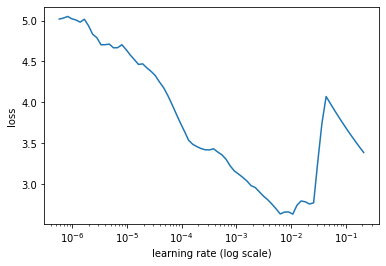

In [206]:
learner.lr_find(show_plot=True)

### Train

In [207]:
learner.autofit(10e-4, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 7s 11ms/sample - loss: 1.5292 - accuracy: 0.5317 - val_loss: 0.6630 - val_accuracy: 0.6111
Epoch 2/1024
647/647 [==============================] - 6s 9ms/sample - loss: 0.4175 - accuracy: 0.8037 - val_loss: 0.7848 - val_accuracy: 0.5988
Epoch 3/1024
640/647 [============================>.] - ETA: 0s - loss: 0.2841 - accuracy: 0.8922
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.0005 (if not early_stopping).
647/647 [==============================] - 6s 9ms/sample - loss: 0.2815 - accuracy: 0.8934 - val_loss: 0.7430 - val_accuracy: 0.6235
Epoch 4/1024
647/647 [==============================] - 6s 9ms/sample - loss: 0.1622 - accuracy: 0.9567 - val_loss: 0.6878 - val_accuracy: 0.6420
Epoch 5/1024
647/647 [==============================] - 6s 

## Examine results

In [208]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           1       0.60      0.62      0.61        65
           0       0.74      0.72      0.73        97

    accuracy                           0.68       162
   macro avg       0.67      0.67      0.67       162
weighted avg       0.68      0.68      0.68       162



array([[40, 25],
       [27, 70]])

## Explain a prediction

In [209]:
import pandas as pd
X_test = pd.read_csv('../data/test.csv')['cleaned_contents']

In [210]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [233]:
i = 9
print(predictor.predict(x_test[i]), y_test[i])

0 1


In [234]:
predictor.explain(x_test[i])

In [238]:
learner.evaluate(test)[1,1]

              precision    recall  f1-score   support

           0       0.60      0.62      0.61        65
           1       0.74      0.72      0.73        97

    accuracy                           0.68       162
   macro avg       0.67      0.67      0.67       162
weighted avg       0.68      0.68      0.68       162



70

In [218]:
x_test.shape

(162,)

In [ ]:
for width in [32, 64, 128, 256]:
    for filters in [16, 32, 64]:
        for dropout in [0.1, 0.2, 0.3, 0.4]:
            f1s = []
            for _ in range(5):
                model = _build_cnn(MAXLEN, len(Embeddings), DIMS, filters=filters, kernels=[2, 3, 4, 5, 6], dropout=dropout, density=width)
                learner = ktrain.get_learner(model, train_data=train, val_data=test)
                learner.autofit(10e-4)
                c_matrix = learner.evaluate(test)
                TP = c_matrix[1,1]
                FN = c_matrix[0,1]
                FP = c_matrix[1,0]
                f1s.append(2 * TP / (2 * TP + FN + FP))
            outstring = str(width) + ',' + str(filters) + ',' + str(dropout) + ',' + str(np.array(f1s).mean()) + '\n'
            print(outstring)
            with open('results.csv', 'a') as f:
                f.write(outstring)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.7007 - accuracy: 0.5070 - val_loss: 0.6704 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6718 - accuracy: 0.5734 - val_loss: 0.6662 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6619 - accuracy: 0.5858 - val_loss: 0.6602 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6491 - accuracy: 0.5920 - val_loss: 0.6528 - val_accuracy: 0.6235
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6414 - accuracy: 0.6522 - val_loss: 0.6499 - val_accuracy: 0.6605
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 7s 11ms/sample - loss: 0.6880 - accuracy: 0.5456 - val_loss: 0.6709 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 6s 9ms/sample - loss: 0.6622 - accuracy: 0.6105 - val_loss: 0.6677 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 6s 10ms/sample - loss: 0.6591 - accuracy: 0.6182 - val_loss: 0.6505 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 6s 10ms/sample - loss: 0.6220 - accuracy: 0.6368 - val_loss: 0.6323 - val_accuracy: 0.6481
Epoch 5/1024
647/647 [==============================] - 6s 9ms/sample - loss: 0.5894 - accuracy: 0.7249 - val_loss: 0.6190 - val_accuracy: 0.6728
Epoch 6/1024
647/647 [===============

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6877 - accuracy: 0.5719 - val_loss: 0.6789 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6785 - accuracy: 0.5719 - val_loss: 0.6763 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6630 - accuracy: 0.5796 - val_loss: 0.6603 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6484 - accuracy: 0.6321 - val_loss: 0.6479 - val_accuracy: 0.5988
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6228 - accuracy: 0.6260 - val_loss: 0.6340 - val_accuracy: 0.6543
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6850 - accuracy: 0.5719 - val_loss: 0.6708 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6736 - accuracy: 0.5734 - val_loss: 0.6606 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6561 - accuracy: 0.5796 - val_loss: 0.6473 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6342 - accuracy: 0.6337 - val_loss: 0.6322 - val_accuracy: 0.6173
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.5999 - accuracy: 0.6924 - val_loss: 0.6148 - val_accuracy: 0.6790
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 5s 8ms/sample - loss: 0.6872 - accuracy: 0.5410 - val_loss: 0.6699 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 5s 8ms/sample - loss: 0.6770 - accuracy: 0.5734 - val_loss: 0.6638 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6639 - accuracy: 0.5981 - val_loss: 0.6604 - val_accuracy: 0.6235
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6466 - accuracy: 0.6306 - val_loss: 0.6460 - val_accuracy: 0.6481
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6180 - accuracy: 0.7187 - val_loss: 0.6376 - val_accuracy: 0.6852
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 6s 9ms/sample - loss: 0.6872 - accuracy: 0.5626 - val_loss: 0.6717 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6706 - accuracy: 0.5719 - val_loss: 0.6651 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6581 - accuracy: 0.5827 - val_loss: 0.6551 - val_accuracy: 0.6049
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6352 - accuracy: 0.6321 - val_loss: 0.6380 - val_accuracy: 0.6728
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6025 - accuracy: 0.7125 - val_loss: 0.6237 - val_accuracy: 0.6481
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6984 - accuracy: 0.5070 - val_loss: 0.6719 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6728 - accuracy: 0.5719 - val_loss: 0.6640 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 4ms/sample - loss: 0.6644 - accuracy: 0.5657 - val_loss: 0.6773 - val_accuracy: 0.5926
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6431 - accuracy: 0.6522 - val_loss: 0.6401 - val_accuracy: 0.6235
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6092 - accuracy: 0.7017 - val_loss: 0.6238 - val_accuracy: 0.6296
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6842 - accuracy: 0.5719 - val_loss: 0.6760 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6760 - accuracy: 0.5750 - val_loss: 0.6659 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6590 - accuracy: 0.5811 - val_loss: 0.6581 - val_accuracy: 0.6358
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6403 - accuracy: 0.6430 - val_loss: 0.6409 - val_accuracy: 0.6296
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6082 - accuracy: 0.7110 - val_loss: 0.6249 - val_accuracy: 0.6481
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6871 - accuracy: 0.5641 - val_loss: 0.6722 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6743 - accuracy: 0.5719 - val_loss: 0.6642 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6612 - accuracy: 0.5765 - val_loss: 0.6549 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 4ms/sample - loss: 0.6454 - accuracy: 0.6043 - val_loss: 0.6559 - val_accuracy: 0.6420
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6161 - accuracy: 0.6986 - val_loss: 0.6229 - val_accuracy: 0.6667
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6859 - accuracy: 0.5595 - val_loss: 0.6723 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6779 - accuracy: 0.5719 - val_loss: 0.6671 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6645 - accuracy: 0.5889 - val_loss: 0.6623 - val_accuracy: 0.6481
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6455 - accuracy: 0.6291 - val_loss: 0.6459 - val_accuracy: 0.5988
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6280 - accuracy: 0.6600 - val_loss: 0.6349 - val_accuracy: 0.6852
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6918 - accuracy: 0.5255 - val_loss: 0.6696 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 4ms/sample - loss: 0.6707 - accuracy: 0.5827 - val_loss: 0.6698 - val_accuracy: 0.6852
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6570 - accuracy: 0.6291 - val_loss: 0.6501 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6288 - accuracy: 0.6476 - val_loss: 0.6402 - val_accuracy: 0.6605
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6012 - accuracy: 0.7079 - val_loss: 0.6289 - val_accuracy: 0.6420
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6807 - accuracy: 0.5750 - val_loss: 0.6697 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6673 - accuracy: 0.5904 - val_loss: 0.6666 - val_accuracy: 0.6049
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6531 - accuracy: 0.6121 - val_loss: 0.6567 - val_accuracy: 0.6420
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6317 - accuracy: 0.6893 - val_loss: 0.6412 - val_accuracy: 0.6111
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6132 - accuracy: 0.6569 - val_loss: 0.6254 - val_accuracy: 0.6358
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6830 - accuracy: 0.5611 - val_loss: 0.6694 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6740 - accuracy: 0.5750 - val_loss: 0.6613 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6577 - accuracy: 0.5920 - val_loss: 0.6541 - val_accuracy: 0.6420
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6396 - accuracy: 0.6522 - val_loss: 0.6363 - val_accuracy: 0.6049
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6101 - accuracy: 0.6723 - val_loss: 0.6215 - val_accuracy: 0.6852
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6841 - accuracy: 0.5533 - val_loss: 0.6727 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6811 - accuracy: 0.5796 - val_loss: 0.6700 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6660 - accuracy: 0.5796 - val_loss: 0.6592 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6485 - accuracy: 0.6167 - val_loss: 0.6508 - val_accuracy: 0.6173
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6365 - accuracy: 0.6352 - val_loss: 0.6507 - val_accuracy: 0.6358
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6822 - accuracy: 0.5703 - val_loss: 0.6748 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6814 - accuracy: 0.5811 - val_loss: 0.6748 - val_accuracy: 0.6049
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6658 - accuracy: 0.5981 - val_loss: 0.6595 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6426 - accuracy: 0.6198 - val_loss: 0.6461 - val_accuracy: 0.6049
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6150 - accuracy: 0.6692 - val_loss: 0.6330 - val_accuracy: 0.6481
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6912 - accuracy: 0.5626 - val_loss: 0.6769 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6827 - accuracy: 0.5703 - val_loss: 0.6703 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6689 - accuracy: 0.5765 - val_loss: 0.6647 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6534 - accuracy: 0.5951 - val_loss: 0.6572 - val_accuracy: 0.6111
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6324 - accuracy: 0.6832 - val_loss: 0.6432 - val_accuracy: 0.6543
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6940 - accuracy: 0.5147 - val_loss: 0.6744 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6769 - accuracy: 0.5719 - val_loss: 0.6721 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6665 - accuracy: 0.5734 - val_loss: 0.6626 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6477 - accuracy: 0.6213 - val_loss: 0.6603 - val_accuracy: 0.6296
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6336 - accuracy: 0.6399 - val_loss: 0.6440 - val_accuracy: 0.6296
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6849 - accuracy: 0.5641 - val_loss: 0.6768 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6817 - accuracy: 0.5719 - val_loss: 0.6670 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6634 - accuracy: 0.5781 - val_loss: 0.6609 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6520 - accuracy: 0.6260 - val_loss: 0.6527 - val_accuracy: 0.6852
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6303 - accuracy: 0.6986 - val_loss: 0.6281 - val_accuracy: 0.6543
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6874 - accuracy: 0.5564 - val_loss: 0.6743 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6744 - accuracy: 0.5703 - val_loss: 0.6692 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6645 - accuracy: 0.5858 - val_loss: 0.6628 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6498 - accuracy: 0.6121 - val_loss: 0.6531 - val_accuracy: 0.6296
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6234 - accuracy: 0.6816 - val_loss: 0.6412 - val_accuracy: 0.6543
Epoch 6/1024
647/647 [==================

/usr/local/lib/python3.6/dist-packages/ktrain/core.py:41: UserWarning: Could not save original model weights
  warnings.warn('Could not save original model weights')


early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 4s 6ms/sample - loss: 0.6915 - accuracy: 0.5641 - val_loss: 0.6781 - val_accuracy: 0.5988
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6772 - accuracy: 0.5719 - val_loss: 0.6735 - val_accuracy: 0.5988
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6701 - accuracy: 0.5873 - val_loss: 0.6665 - val_accuracy: 0.5988
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6612 - accuracy: 0.5889 - val_loss: 0.6615 - val_accuracy: 0.5988
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6454 - accuracy: 0.6074 - val_loss: 0.6547 - val_accuracy: 0.6543
Epoch 6/1024
647/647 [==================

In [246]:
os.getcwd()

'/notebooks/w266/w266_project/CNNs'

In [248]:
outstring

NameError: name 'outstring' is not defined